In [47]:
import os
from pathlib import Path

input_dir = Path(r"/home/plorenc/Desktop/AiR_ISS/ML/lab9/images")
target_dir = Path("/home/plorenc/Desktop/AiR_ISS/ML/lab9/annotations/trimaps")

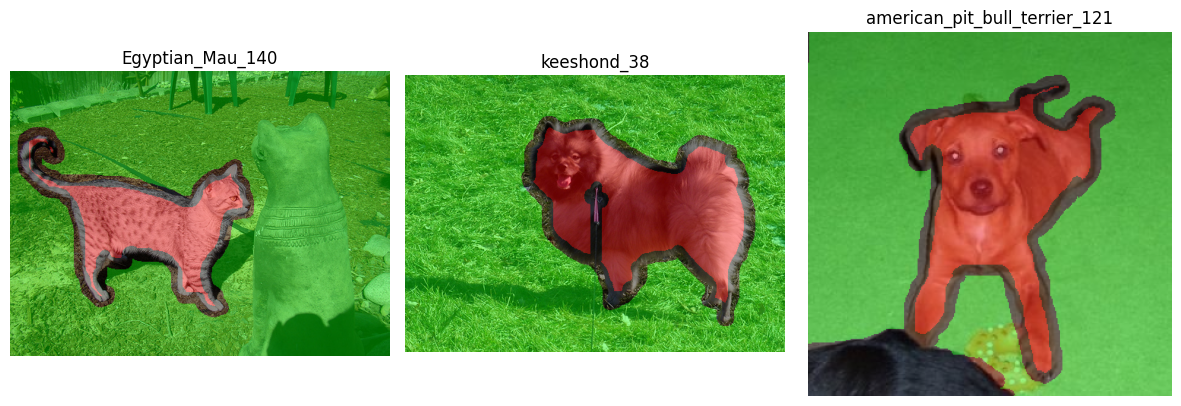

In [48]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from pathlib import Path

input_dir = Path("/home/plorenc/Desktop/AiR_ISS/ML/lab9/images")
target_dir = Path("/home/plorenc/Desktop/AiR_ISS/ML/lab9/annotations/trimaps")

input_files = sorted([p for p in input_dir.glob("*.jpg") if not p.name.startswith('.')])
target_files = sorted([p for p in target_dir.glob("*.png") if not p.name.startswith('.')])

image_map = {p.stem: p for p in input_files}
mask_map = {p.stem: p for p in target_files}

common_keys = list(set(image_map.keys()) & set(mask_map.keys()))

samples = random.sample(common_keys, 3)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, key in enumerate(samples):
    img_path = image_map[key]
    mask_path = mask_map[key]

    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    mask_rgb[mask == 1] = [255, 0, 0]
    mask_rgb[mask == 2] = [0, 255, 0]

    axs[i].imshow(img)
    axs[i].imshow(mask_rgb, alpha=0.4)
    axs[i].axis('off')
    axs[i].set_title(key)

plt.tight_layout()
plt.show()


In [49]:
i_new = []
t_new = []

for i, t in zip(input_files, target_files):
    img = cv2.imread(i)
    target = cv2.imread(t)

    if img is not None and target is not None:
        i_new.append(i)
        t_new.append(t)
    else:
        print(f"[Błąd] Nie udało się wczytać:\n  obraz: {i if img is None else 'OK'}\n  maska: {t if target is None else 'OK'}")


[Błąd] Nie udało się wczytać:
  obraz: /home/plorenc/Desktop/AiR_ISS/ML/lab9/images/Abyssinian_34.jpg
  maska: OK
[Błąd] Nie udało się wczytać:
  obraz: /home/plorenc/Desktop/AiR_ISS/ML/lab9/images/Egyptian_Mau_139.jpg
  maska: OK
[Błąd] Nie udało się wczytać:
  obraz: /home/plorenc/Desktop/AiR_ISS/ML/lab9/images/Egyptian_Mau_145.jpg
  maska: OK
[Błąd] Nie udało się wczytać:
  obraz: /home/plorenc/Desktop/AiR_ISS/ML/lab9/images/Egyptian_Mau_167.jpg
  maska: OK
[Błąd] Nie udało się wczytać:
  obraz: /home/plorenc/Desktop/AiR_ISS/ML/lab9/images/Egyptian_Mau_177.jpg
  maska: OK
[Błąd] Nie udało się wczytać:
  obraz: /home/plorenc/Desktop/AiR_ISS/ML/lab9/images/Egyptian_Mau_191.jpg
  maska: OK


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(i_new, t_new, test_size=0.2, random_state=42)

In [51]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import cv2

transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])


class imgDataset(Dataset):
    def __init__(self, img_path, img_target, transform=None):
        self.img_path = img_path
        self.img_target = img_target
        self.transform = transform if transform else transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_path)
    
    @staticmethod
    def open_image(path):
        return cv2.imread(path, cv2.IMREAD_COLOR_RGB)
    
    @staticmethod
    def open_target(path):
        return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    def __getitem__(self, index):
        img_path = self.img_path[index]
        target_path = self.img_target[index]

        img = self.open_image(img_path)
        target = self.open_target(target_path)

        if img is None:
            print(f"[Błąd] Nie można wczytać obrazu: {img_path}")
        if mask is None:
            print(f"[Błąd] Nie można wczytać maski: {mask_path}")


        mask_rgb = np.zeros((*target.shape, 3), dtype=np.uint8)

        mask_rgb[target == 0] = [0, 0, 255]  
        mask_rgb[target == 1] = [255, 0, 0]   
        mask_rgb[target == 2] = [0, 255, 0] 

        if self.transform:
            img = self.transform(img)
            mask_rgb = self.transform(mask_rgb)

        return img, mask_rgb

In [52]:
train_data = imgDataset(X_train, Y_train, transform)
test_data = imgDataset(X_test, Y_test, transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


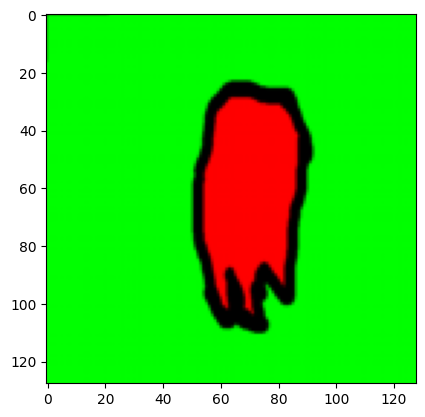

In [53]:
plt.imshow(np.array(next(iter(train_data)))[1].transpose(1, 2, 0))

In [54]:
BATCH_SIZE = 16

def collate_fn_skip_none(batch):
    # odfiltruj próbki, które są None
    batch = [x for x in batch if x is not None]
    return torch.utils.data.default_collate(batch)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_skip_none)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=collate_fn_skip_none)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(out_classes=3)
output = model(torch.randn(1, 3, 128, 128))  

model = model.to(device)
device

device(type='cuda')

In [88]:
from torch import optim
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm

model = model.to(device)

optimizer = optim.Adam(params=model.parameters())
loss_fn = CrossEntropyLoss()

# metryka
def dice_coefficient(preds, targets, epsilon=1e-6):
    preds = preds.float().contiguous().view(-1)
    targets = targets.float().contiguous().view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + epsilon) / (preds.sum() + targets.sum() + epsilon)


num_epochs = 10

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # === TRAINING ===
    model.train()
    train_loss = 0.0
    train_dice = 0.0

    for images, masks in tqdm(train_dataloader, desc='Training'):
        
        images = images.to(device)
        masks = masks.to(device)
        masks = torch.argmax(masks, dim=1)  # Zakładamy one-hot maski

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        dice = dice_coefficient((preds == 1).float(), (masks == 1).float())

        train_loss += loss.item()
        train_dice += dice.item()

        # Sprzątanie
        del images, masks, outputs, preds, loss, dice
        torch.cuda.empty_cache()

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_dice = train_dice / len(train_dataloader)

    print(f"Train Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}")



Epoch 1/10


Training: 100%|██████████| 370/370 [02:26<00:00,  2.53it/s]


Train Loss: 0.1982, Dice: 0.9332

Epoch 2/10


Training: 100%|██████████| 370/370 [02:30<00:00,  2.46it/s]


Train Loss: 0.1856, Dice: 0.9383

Epoch 3/10


Training: 100%|██████████| 370/370 [02:32<00:00,  2.42it/s]


Train Loss: 0.1762, Dice: 0.9414

Epoch 4/10


Training: 100%|██████████| 370/370 [02:33<00:00,  2.41it/s]


Train Loss: 0.1645, Dice: 0.9458

Epoch 5/10


Training: 100%|██████████| 370/370 [02:34<00:00,  2.40it/s]


Train Loss: 0.1603, Dice: 0.9471

Epoch 6/10


Training: 100%|██████████| 370/370 [02:34<00:00,  2.39it/s]


Train Loss: 0.1529, Dice: 0.9496

Epoch 7/10


Training: 100%|██████████| 370/370 [02:33<00:00,  2.41it/s]


Train Loss: 0.1390, Dice: 0.9543

Epoch 8/10


Training: 100%|██████████| 370/370 [02:34<00:00,  2.40it/s]


Train Loss: 0.1358, Dice: 0.9553

Epoch 9/10


Training: 100%|██████████| 370/370 [02:34<00:00,  2.40it/s]


Train Loss: 0.1269, Dice: 0.9581

Epoch 10/10


Training: 100%|██████████| 370/370 [02:35<00:00,  2.38it/s]

Train Loss: 0.1226, Dice: 0.9596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08736746..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0020386472..1.0000001].


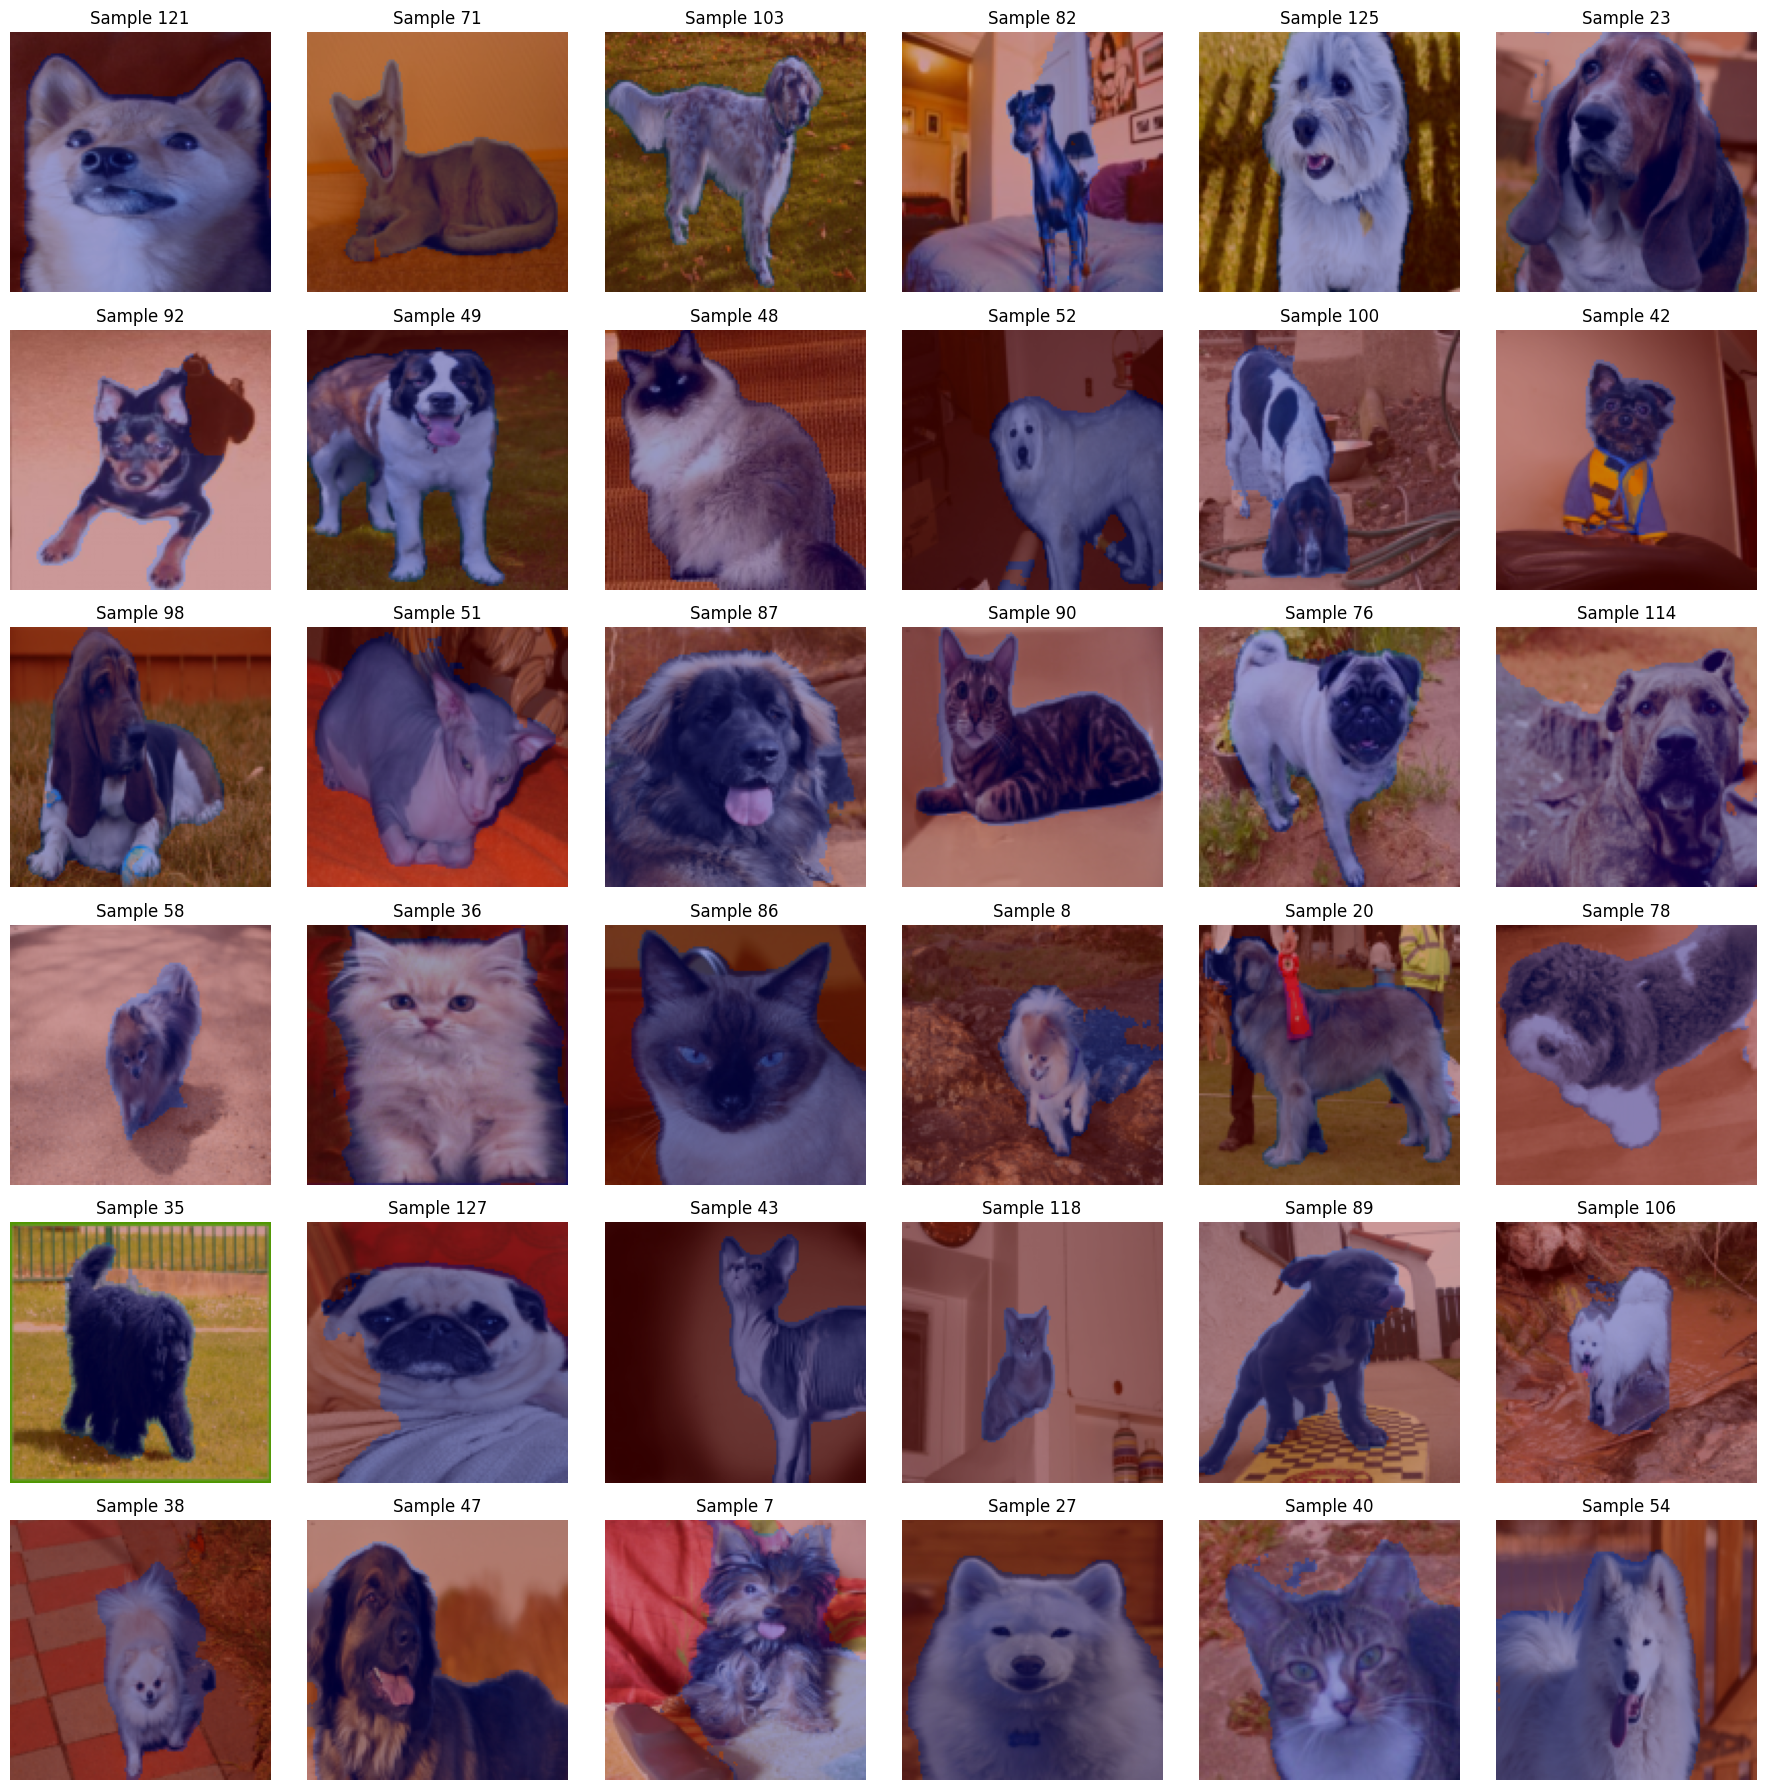

In [90]:
model = model.to('cpu')
model.eval()

# Pobierz wszystkie przykłady z test_dataloader
all_images, all_masks = next(iter(test_dataloader))

# Losowo wybierz 36 indeksów
indices = random.sample(range(len(all_images)), 36)

plt.figure(figsize=(18, 18))

for i, idx in enumerate(indices):
    image = all_images[idx]        # [C, H, W]
    mask = all_masks[idx]          # [C, H, W] jeśli one-hot

    # Jeśli maska jest one-hot encoded, zredukuj do [H, W]
    if mask.ndim == 3 and mask.shape[0] > 1:
        mask = torch.argmax(mask, dim=0)

    with torch.no_grad():
        output = model(image.unsqueeze(0))  # [1, C, H, W]
        pred = torch.argmax(output, dim=1).squeeze(0)  # [H, W]

    # Konwersja do NumPy
    img_np = image.permute(1, 2, 0).numpy()  # [H, W, C]
    pred_np = pred.numpy()

    # Wyświetl obraz z nałożoną maską predykcji
    plt.subplot(6, 6, i + 1)
    plt.imshow(img_np)
    plt.imshow(pred_np, cmap='jet', alpha=0.4)  # predykcja jako półprzezroczysta mapa
    plt.axis('off')
    plt.title(f"Sample {idx}")

plt.tight_layout()
plt.show()